# COMP 9444 Final Project
## Toxic text Classification
### In this notebook, we use pre-trained BERT model for Multiclass

In recent years, online hate or offensive comments have proliferated on social media platforms and online discussions. It only takes one toxic word in online forums and social platforms to sour an online discussion on the web. Toxic comments are harming all social platforms.

Thus it is essential to automatically detect and warn of toxic comments on social platforms and flag them for removal. In response, our project attempts to build two models to detect different toxicity types, each of which performs binary and multi-class classification. We first fine-tuned the pre-trained BERT model on the comments dataset from the Wikipedia discussion page editor. And then, we proposed a bi-direction LSTM model to approach the performance of our pre-trained Bert model. We observed that the pre-trained model is not better than the simple model in all metrics.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import get_linear_schedule_with_warmup
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import os
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

In [2]:
data_folder_path = './data/'

Our data comes from: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In this project, we adopt a real-world dataset: jigsaw-toxic- comment from Kaggle, which is a collection of Wikipedia comments labelled manually for toxic behaviour 1. The toxic labels are in 6 categories which are toxic, severe toxic, obscene, threat, insult and identity hate.

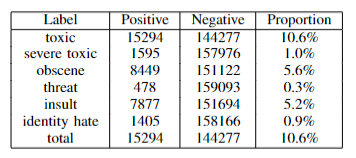

In [3]:
df = pd.read_csv(data_folder_path + 'train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [5]:
df[df[classes[1]] == 1].sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
84701,e29fedad89050eb1,LEAVE THE FCKING PAGE THE WAY I EDIT IT YOU ASS,1,1,1,0,1,0
20001,34db1522cd3cac44,You are such a useless bitch! I mean do you ha...,1,1,1,0,1,0
27450,48a6c30c8ed77d59,FUCK YOU FUCK YOU FUCK YOU \r\n\r\nFFFFFFFFUUU...,1,1,1,0,1,0
42022,7018f85aa5664bcd,F*CKING SON OF A BATCH MOTHER F*CKER. Rolling...,1,1,1,0,1,0
152581,8f92f734bf5d722c,WRITE YOUR FUYCKING DISCOUSSION HERE YOU FUCK ...,1,1,1,0,1,0


Each comment can have more than one label.

In [6]:
test_data = pd.read_csv(data_folder_path + 'test.csv')
test_labels = pd.read_csv(data_folder_path + 'test_labels.csv')
test_data = pd.concat([test_data, test_labels], axis=1)

In [7]:
total_samples = df.shape[0]
for cls in classes:
    rate = df[cls].sum() / total_samples
    rate = np.round(rate*100, 3)
    print(cls +' rate: ', rate, "%")

toxic rate:  9.584 %
severe_toxic rate:  1.0 %
obscene rate:  5.295 %
threat rate:  0.3 %
insult rate:  4.936 %
identity_hate rate:  0.88 %


## Data cleaning

Our data cleaning will replace nonsense symbols like '\n' '\r' and etc. with spaces.

We delete website URLs since this content is not related to our task.

Drop rows in test set which has '-1' value.

In [8]:
def data_cleaning(text):
    # seems that Uppercase words have more effect on toxicity than lowercase.
    # so I decided to keep them as they are.
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")

    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [9]:
df['clean_comment'] = df['comment_text'].apply(data_cleaning)
test_data['clean_comment'] = test_data['comment_text'].apply(data_cleaning)

## Data Augmentation

Another approach we experimented with to mitigate the class imbalance problem is to use data augmentation on the training set to create additional samples for toxic categories. We randomly replaced words in toxic comments with their synonyms at a probability of 0.7. 

Next, we concatenate the original dataset with these created samples as our new training set.


In [10]:
toxic_df = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]
non_toxic_df = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]

In [11]:
replacement_rate =0.7
##  synonym replacement
aug_toxic_df = toxic_df.copy(True)
for i, row in toxic_df.iterrows():
    comment = row['clean_comment']
    words = comment.split()
    new_comment = ''
    new_words = []
    for word in words:
        if word in stopwords.words('english'):
            new_words.append(word)
            continue

        random_rate = np.random.uniform(0, 1)

        if random_rate < replacement_rate:
            synonyms = []
            for syn in wordnet.synsets(word):
                for l in syn.lemmas():
                    synonyms.append(l.name())
            if len(synonyms) > 0:
                new_word = synonyms[np.random.randint(0, len(synonyms))]
                new_words.append(new_word)
            else:
                new_words.append(word)


        else:
            new_words.append(word)
    new_comment = ' '.join(new_words)
    new_row = row.copy(True)
    new_row['clean_comment'] = new_comment
    aug_toxic_df = aug_toxic_df.append(new_row, ignore_index=True)

In [12]:
len(aug_toxic_df)

32450

## Tokenization

In [15]:
df = pd.concat([aug_toxic_df, non_toxic_df], ignore_index=True)
seed = 42
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=seed)
valid_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment
128273,3aa02d4d6d40c3fb,I was testing my professor's hypothesis to see...,0,0,0,0,0,0,I was testing my professor's hypothesis to see...
112912,efe66c3a93b3c3ef,"""\n\nFlan etc.\n\nHi, thanks for contributing ...",0,0,0,0,0,0,""" Flan etc. Hi, thanks for contributing to t..."
63154,5b7a4a339249c482,One-time events aren't tenants of a building. ...,0,0,0,0,0,0,One-time events aren't tenants of a building. ...
90188,ac2c81c95d47c67d,Introduction \nI think there is a bit to much ...,0,0,0,0,0,0,Introduction I think there is a bit to much o...
25255,eb2d0d0f621f689a,You base your information on opinion. You're a...,1,0,0,0,1,0,You ground your information on opinion. You're...


In [16]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [18]:
# encoded_comment = [tokenizer.encode(sent, add_special_tokens=True) for sent in train_df['clean_comment']]
# comment_len = [len(x) for x in encoded_comment]
# np.max(comment_len), np.quantile(comment_len, 0.97), np.mean(comment_len), np.median(comment_len), np.min(comment_len)

97% of the comments are less than 436 tokens, and longer comments always tend to be non-toxic. so I decided to use max_len = 436.

In [19]:
MAX_LEN = 436

In [ ]:
class BertDataSet(Dataset):
    def __init__(self, dataframe):
        self.comments = dataframe['clean_comment'].values
        self.labels = dataframe[classes].to_numpy()

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        tokenized_comment = tokenizer.encode_plus(comment,
                                                    add_special_tokens=True,
                                                    max_length = MAX_LEN,
                                                    padding='max_length',
                                                    truncation = True,
                                                    return_attention_mask = True)
        ids = torch.tensor(tokenized_comment['input_ids'], dtype=torch.long)
        mask = torch.tensor(tokenized_comment['attention_mask'], dtype=torch.long)

        labels = self.labels[idx]
        labels = torch.tensor(labels, dtype=torch.float)
        return {'ids': ids, 'mask': mask, 'labels': labels}


In [ ]:
dataset_train = BertDataSet(train_df)
dataset_test = BertDataSet(valid_df)

In [ ]:
len(dataset_train), len(dataset_test)

In [ ]:
for td in dataset_test:
    print(td['ids'].shape, td['mask'].shape, td['labels'].shape)
    break

In [ ]:
train_batch = 1
test_batch = 1

In [ ]:
data_loader_train = DataLoader(dataset_train, batch_size=train_batch, shuffle=True, pin_memory = True)
data_loader_test = DataLoader(dataset_test, batch_size=test_batch, shuffle=False, pin_memory = True)

### BERT

In our project, the first model we experimented with is BERT, a Pre-trained NLP model based on the transformer network proposed by Jacob et al. 

Unlike the encoder-decoder architecture that the transformer proposed, the BERT network only contains an encoder that is trained by predicting masked words and distinguishing if the second sentence in a given pair of sentences is the subsequent sentence in the original document. As a result of this training process BERT learns contextual embeddings for words that could be used in a wide range of applications. 

After pretraining, which requires a significant investment in computational power, BERT may be fine-tuned on smaller datasets with fewer resources to maximise its performance on specific tasks. BERT is a powerful network for text classification and outperforms traditional RNN-based networks in many tasks. 

As a pre-trained model, BERT is also much less computationally intensive to train, and there are few hyperparameters to tune. All of these advantages make BERT a suitable method to experiment with for our task of toxic comment classification.

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 6)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")
    # model = torch.nn.DataParallel(model)    # multi-gpu
model.to(device)

loss = torch.nn.BCEWithLogitsLoss()
loss.to(device)
for batch in data_loader_train:
    ids = batch['ids'].to(device)
    mask = batch['mask'].to(device)
    outputs = model(ids, attention_mask=mask)
    outputs = outputs['logits'].squeeze(-1).to(torch.float32)
    probabilities = torch.sigmoid(outputs)
    predictions = torch.where(probabilities > 0.5, 1, 0)
    labels = batch['labels'].to(device, non_blocking=True)
    loss_value = loss(outputs, labels)
    print(loss_value.item())
    correct_predictions = torch.sum(predictions == labels)
    print(correct_predictions.item())
    break

## Loss Function with Customized Weight

In [ ]:
loss = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor((159571 - 35098) / 35098))
loss.to(device)
epochs = 5
LR = 2e-5 #Learning rate
optimizer = torch.optim.AdamW(model.parameters(), LR, weight_decay = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, verbose = True)
torch.backends.cudnn.benchmark = True

In [ ]:

for i in range(epochs):
    model.train()
    correct_predictions = 0
    for batch_id, batch in enumerate(data_loader_train):
        optimizer.zero_grad()
        train_losses = []
        with torch.cuda.amp.autocast():
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            optimizer.zero_grad()
            outputs = model(ids, mask)

            outputs = outputs['logits'].squeeze(-1).to(torch.float32)
            print('outputs', outputs)
            probabilities = torch.sigmoid(outputs)
            print('probabilities', probabilities.requires_grad)
            predictions = torch.where(probabilities > 0.5, 1, 0)

            print('predictions', predictions.requires_grad)

            labels = batch['labels'].to(device, non_blocking=True)
            print('dtype_labels', labels.dtype)
            print('predictions', predictions)
            print('labels', labels.requires_grad)
            loss_value = loss(outputs, labels)
            print('loss_value', loss_value.grad_fn)
            train_losses.append(loss_value.item())
            loss_value.backward()
            correct_predictions += torch.sum(predictions == labels)
        optimizer.step()
        if batch_id % 10 == 0:
            print('Epoch: {}, Batch: {}, Loss: {}'.format(i, batch_id, np.mean(train_losses)))
    accuracy = correct_predictions/(len(dataset_train)*6)
    print('Epoch: {}, Accuracy: {}'.format(i, accuracy))
    model.eval()
    # test
    with torch.no_grad():
        correct_predictions = 0
        test_losses = []
        for batch_id, batch in enumerate(data_loader_test):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            outputs = model(ids, mask)
            outputs = outputs['logits'].squeeze(-1).to(torch.float32)
            probabilities = torch.sigmoid(outputs)
            predictions = torch.where(probabilities > 0.5, 1, 0)
            labels = batch['labels'].to(device, non_blocking=True)

            loss_valid = loss(outputs, labels)
            test_losses.append(loss_valid.item())
            correct_predictions += torch.sum(predictions == labels)
        accuracy = correct_predictions/(len(dataset_test)*6)
        recall = recall_score(labels, predictions)
        print('Epoch: {}, Recall: {}'.format(i, recall))
        print('Epoch: {}, Validation Accuracy: {}, loss: {}'.format(i, accuracy, np.mean(test_losses)))
    torch.save(model.state_dict(), './model_save/{}.pkl'.format(epochs))

In [35]:

for i in range(epochs):
    model.train()
    correct_predictions = 0
    for batch_id, batch in enumerate(data_loader_train):
        optimizer.zero_grad()
        train_losses = []
        with torch.cuda.amp.autocast():
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            optimizer.zero_grad()
            outputs = model(ids, mask)

            outputs = outputs['logits'].squeeze(-1).to(torch.float32)
            print('outputs', outputs)
            probabilities = torch.sigmoid(outputs)
            print('probabilities', probabilities.requires_grad)
            predictions = torch.where(probabilities > 0.5, 1, 0)

            print('predictions', predictions.requires_grad)

            labels = batch['labels'].to(device, non_blocking=True)
            print('dtype_labels', labels.dtype)
            print('predictions', predictions)
            print('labels', labels.requires_grad)
            loss_value = loss(outputs, labels)
            print('loss_value', loss_value.grad_fn)
            train_losses.append(loss_value.item())
            loss_value.backward()
            correct_predictions += torch.sum(predictions == labels)
        optimizer.step()
        if batch_id % 10 == 0:
            print('Epoch: {}, Batch: {}, Loss: {}'.format(i, batch_id, np.mean(train_losses)))
    accuracy = correct_predictions/(len(dataset_train)*6)
    print('Epoch: {}, Accuracy: {}'.format(i, accuracy))
    model.eval()
    # test
    with torch.no_grad():
        correct_predictions = 0
        test_losses = []
        for batch_id, batch in enumerate(data_loader_test):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            outputs = model(ids, mask)
            outputs = outputs['logits'].squeeze(-1).to(torch.float32)
            probabilities = torch.sigmoid(outputs)
            predictions = torch.where(probabilities > 0.5, 1, 0)
            labels = batch['labels'].to(device, non_blocking=True)

            loss_valid = loss(outputs, labels)
            test_losses.append(loss_valid.item())
            correct_predictions += torch.sum(predictions == labels)
        accuracy = correct_predictions/(len(dataset_test)*6)
        recall = recall_score(labels, predictions)
        print('Epoch: {}, Recall: {}'.format(i, recall))
        print('Epoch: {}, Validation Accuracy: {}, loss: {}'.format(i, accuracy, np.mean(test_losses)))
    torch.save(model.state_dict(), './model_save/{}.pkl'.format(epochs))

outputs tensor([[-3.7227, -4.6641, -4.3828, -4.3945, -4.0391, -4.2305]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
probabilities True
predictions False
dtype_labels torch.float32
predictions tensor([[0, 0, 0, 0, 0, 0]], device='cuda:0')
labels False
loss_value <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f823dc8fd30>
Epoch: 0, Batch: 0, Loss: 0.01497495174407959
outputs tensor([[-1.7051, -4.7773, -2.8613, -4.8125, -2.7266, -3.8652]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
probabilities True
predictions False
dtype_labels torch.float32
predictions tensor([[0, 0, 0, 0, 0, 0]], device='cuda:0')
labels False
loss_value <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f823d873c70>
outputs tensor([[-3.8535, -4.3906, -4.2578, -4.1328, -3.9297, -4.2852]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
probabilities True
predictions False
dtype_labels torch.float32
predictions tensor([[0, 0, 0, 0, 0, 0]], device='cuda:0')
labels False
loss_value <BinaryCrossEn

KeyboardInterrupt: 

In [ ]:
print(torch.cuda.memory_summary(1))